In [72]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np
import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation, ReversePermutation

In [73]:
class DatasetMoons:
    """ 
        two half-moons taken from an example 
    """
    def sample(self, n, noise=0.05):
        moons = datasets.make_moons(n_samples=n, noise=noise)[0].astype(np.float32)
        return torch.from_numpy(moons)

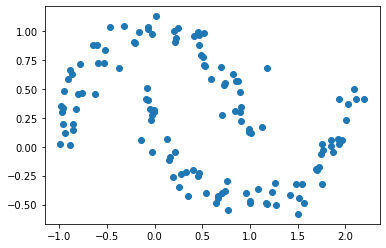

In [74]:
d = DatasetMoons()
x = d.sample(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

In [75]:
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

ipykernel_launcher:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
tensor(1.2061, grad_fn=<NegBackward>)
tensor(1.1647, grad_fn=<NegBackward>)
tensor(1.0810, grad_fn=<NegBackward>)
tensor(1.0634, grad_fn=<NegBackward>)
tensor(1.1071, grad_fn=<NegBackward>)


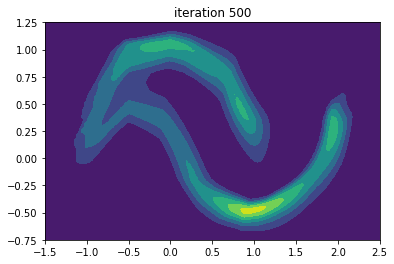

tensor(1.1498, grad_fn=<NegBackward>)
tensor(1.2466, grad_fn=<NegBackward>)
tensor(1.1749, grad_fn=<NegBackward>)
tensor(1.1148, grad_fn=<NegBackward>)
tensor(1.0540, grad_fn=<NegBackward>)


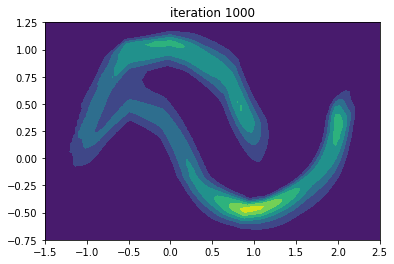

tensor(1.1969, grad_fn=<NegBackward>)
tensor(1.1347, grad_fn=<NegBackward>)
tensor(1.1050, grad_fn=<NegBackward>)
tensor(1.1498, grad_fn=<NegBackward>)
tensor(1.1489, grad_fn=<NegBackward>)


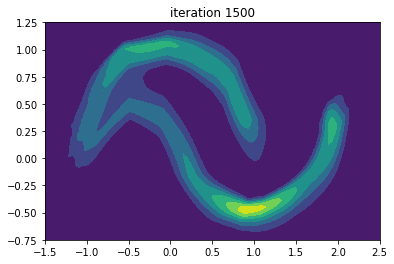

tensor(1.1121, grad_fn=<NegBackward>)
tensor(1.1995, grad_fn=<NegBackward>)
tensor(1.0327, grad_fn=<NegBackward>)
tensor(1.1772, grad_fn=<NegBackward>)
tensor(1.1473, grad_fn=<NegBackward>)


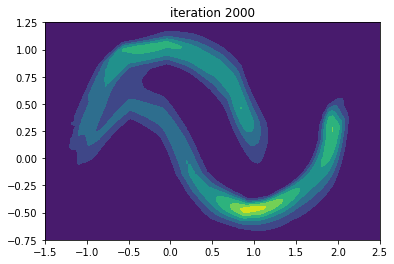

tensor(1.1479, grad_fn=<NegBackward>)
tensor(1.2599, grad_fn=<NegBackward>)
tensor(1.1869, grad_fn=<NegBackward>)
tensor(1.1225, grad_fn=<NegBackward>)
tensor(1.0829, grad_fn=<NegBackward>)


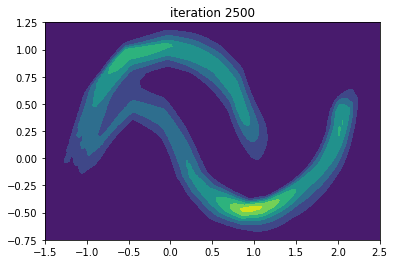

tensor(1.1386, grad_fn=<NegBackward>)
tensor(1.1330, grad_fn=<NegBackward>)
tensor(1.0959, grad_fn=<NegBackward>)
tensor(1.2684, grad_fn=<NegBackward>)
tensor(1.1583, grad_fn=<NegBackward>)


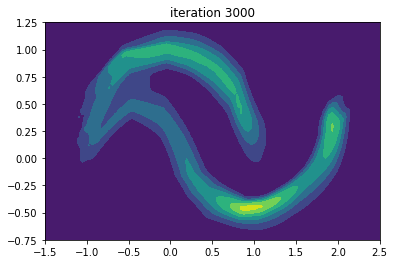

tensor(1.1950, grad_fn=<NegBackward>)
tensor(1.1236, grad_fn=<NegBackward>)
tensor(1.1031, grad_fn=<NegBackward>)
tensor(1.1278, grad_fn=<NegBackward>)
tensor(1.1302, grad_fn=<NegBackward>)


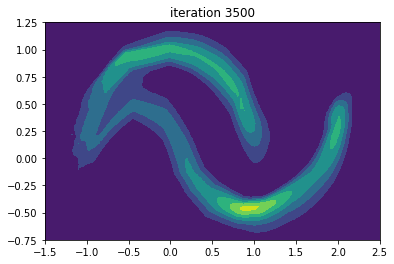

tensor(1.1158, grad_fn=<NegBackward>)
tensor(1.0198, grad_fn=<NegBackward>)
tensor(1.1875, grad_fn=<NegBackward>)
tensor(1.1759, grad_fn=<NegBackward>)
tensor(1.1589, grad_fn=<NegBackward>)


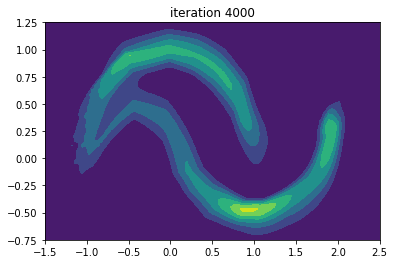

tensor(1.1077, grad_fn=<NegBackward>)
tensor(1.1322, grad_fn=<NegBackward>)
tensor(1.1640, grad_fn=<NegBackward>)
tensor(1.0835, grad_fn=<NegBackward>)
tensor(1.0270, grad_fn=<NegBackward>)


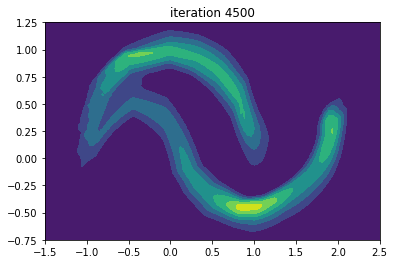

tensor(1.0761, grad_fn=<NegBackward>)
tensor(0.9958, grad_fn=<NegBackward>)
tensor(1.0841, grad_fn=<NegBackward>)
tensor(1.1686, grad_fn=<NegBackward>)
tensor(1.1589, grad_fn=<NegBackward>)


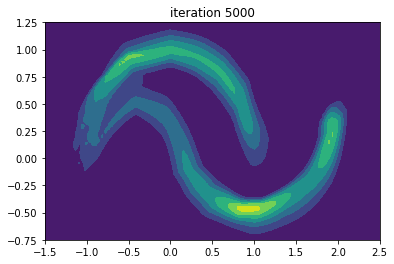

In [78]:
flow.train()
num_iter = 5000
for i in range(num_iter):
    x = d.sample(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()

    if i % 100 == 0: 
        print(loss[0])
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

tensor([-0.9794,  0.3529], grad_fn=<SelectBackward>)
tensor([ 1.6401, -0.2506], grad_fn=<SelectBackward>)
(1024, 2)
(256, 2)
torch.Size([256, 2])


Text(0.5, 1.0, 'z -> x')

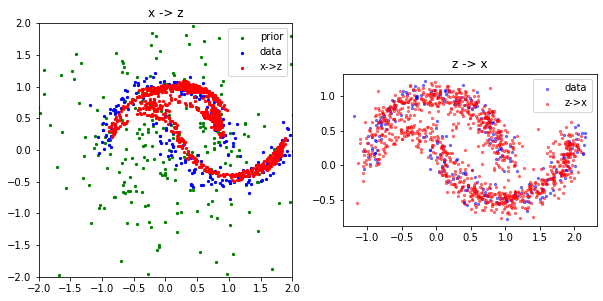

In [85]:
flow.eval()
# this is the data 
x = d.sample(256, noise=0.1)
# This is the output from the NF model by taking sampling values x and going to z x->z  
z = flow.sample(128*8)
z2, logabsdet = transform.inverse(z)

print(z[0])
print(z2[0])

x = x.detach().numpy()
z = z.detach().numpy()
z2 = z2.detach().numpy()
# This is sampling from the prior distribution 
p = base_dist.sample(256)

print(z.shape)
print(x.shape)
print(p.shape)


plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.scatter(z2[:,0], z2[:,1], c='r', s=5)
plt.legend(['prior', 'data', 'x->z', "other"])
plt.axis('scaled')
plt.ylim(-2, 2)
plt.xlim(-2, 2)
plt.title('x -> z')

z = flow.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

SyntaxError: invalid syntax (<ipython-input-87-0f3d753efdbe>, line 1)